In [21]:
import os
import random
from numpy.random import rand
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import layers
import time
%matplotlib inline
# plt.rcParams['figure.figsize'] = [8, 6]
# plt.rcParams['figure.titlesize'] = 24
# plt.rcParams['axes.labelsize'] = 18
# plt.rcParams['axes.titlesize'] = 20
# plt.rcParams['xtick.labelsize'] = 16
# plt.rcParams['ytick.labelsize'] = 16
# plt.rcParams['legend.fontsize'] = 16

## Initialize GPU

In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

In [3]:
def set_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

## Construct the Hamiltonian
the following function outputs vectorized Hamiltonian and quadrupole moment. q_tot has shape (dim_kx, dim_ky, 16*2).

In [4]:
def quadmodel_generator(N=32):
    
    kr = np.linspace(0, 2 * np.pi, N)
    kx, ky = np.meshgrid(kr, kr) # row corresponds to y, column corresponds to x
    while True:
        
        g1 = - np.kron([[0, -1j], [1j, 0]], [[0, 1], [1, 0]])
        g2 = - np.kron([[0, -1j], [1j, 0]], [[0, -1j], [1j, 0]])
        g3 = - np.kron([[0, -1j], [1j, 0]], [[1, 0], [0, -1]])
        g4 = np.kron([[0, 1], [1, 0]], np.eye(2))

#         ### Shuffle the representaion
#         s0 = [ [1,0] , [0,1] ] 
#         s1 = [ [0,1] , [1,0] ]
#         s2 = [ [0,-1j] , [1j , 0] ]
#         s3 = [ [1,0] , [0,-1] ]
#         s = np.array( [s0,s1,s2,s3] ) 
        
#         ind = int( rand() *3 + 1 ) 
#         ind2 = np.setdiff1d( [1,2,3] , ind )
        
#         g1 = -np.kron( s[ind] , s[1] ) 
#         g2 = -np.kron( s[ind] , s[2] ) 
#         g3 = -np.kron( s[ind] , s[3] ) 
#         g4 = np.kron( s[int(ind2[[0]])] , s[0] ) 
#         g5 = np.kron( s[int(ind2[[1]])] , s[0] ) 
        
#         g = np.array( [ g1 , g2 , g3 , g4 , g5 ] ) 
        
#         GG = np.zeros(g.shape,dtype=complex)
#         ind3 = np.random.permutation(5)
# #         print(ind3)
#         for i in range(5):
#             GG[i] = g[ind3[i]]
        
#         g1 = GG[0]
#         g2 = GG[1]
#         g3 = GG[2]
#         g4 = GG[3]
#         g5 = GG[4] 
# #         print(g1)

#         ### END: Shuffle the representaion

        coef = np.random.uniform(-1.5, 1.5, 2) # coupling lx, ly between [-2, 2]
        h = (np.kron((coef[0] + np.cos(kx)), g4.flatten()) + np.kron(np.sin(kx), g3.flatten()) + 
             np.kron((coef[1] + np.cos(ky)), g2.flatten()) + np.kron(np.sin(ky), g1.flatten())).reshape((N, N, 16))
        hr, hi = np.real(h), np.imag(h)
        h_tot = np.concatenate((hr, hi), axis = 2) # h_tot has dimension (dim_kx, dim_ky, 16*2)    
        if abs(coef[0]) < 1 and abs(coef[1]) < 1:
            q = 1
        else:
            q = 0
        yield h_tot, q


## Visualize the hamiltonian

In [5]:
def plot_hamiltonian(h, q):
    dim_k = h.shape[0]
    assert dim_k == h.shape[1]
    assert h.shape[2] == 32
    ham_32 = np.zeros((dim_k * 4, dim_k * 8))
    for i in range(4):
        for j in range(4):
            ham_32[ i * dim_k : (i + 1) * dim_k , j * dim_k : (j + 1) * dim_k ] = h[ :, :, i * 4 + j ]
    for i in range(4):
        for j in range(4,8,1):
            ham_32[ i * dim_k : (i + 1) * dim_k , j * dim_k : (j + 1) * dim_k ] = h[ :, :, (4-1)*4 + i * 4 + j ]        
    plt.figure(figsize=(16, 8))
#     plt.imshow(ham_32, cmap='viridis')
    plt.imshow(ham_32, cmap='viridis', vmin=-2.5, vmax=2.5)
    plt.title('q={}'.format(q))
    plt.colorbar()  
    

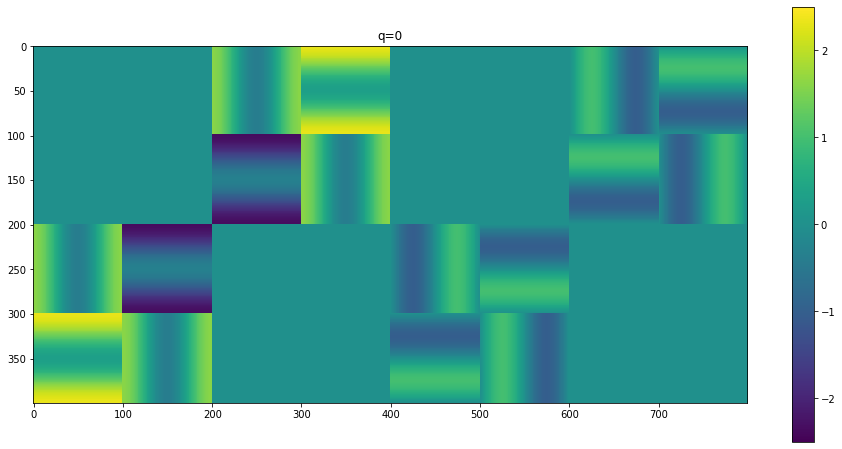

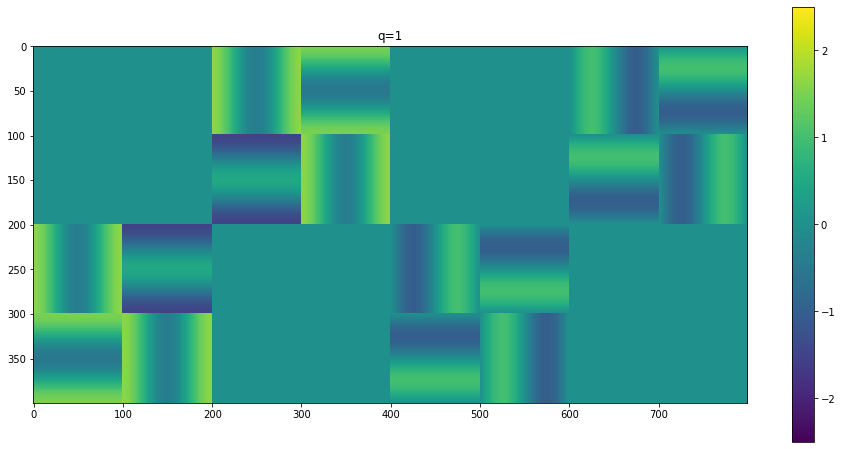

In [6]:
gen_ex = quadmodel_generator(N=100)
while True:
    h, q = next(gen_ex)
    if q == 0:
        plot_hamiltonian(h, q)
        while q != 1:
            h, q = next(gen_ex)
        plot_hamiltonian(h, q)
        break

## Generate the data

In [7]:
def generate_data(size, dim_k):
    X = np.zeros((size, dim_k, dim_k, 32))
    y = np.zeros(size)
    gen = quadmodel_generator(dim_k)
    for i in range(size):
        X[i, :], y[i] = next(gen)
    return X, y        

## Load the data

In [12]:
import numpy as np
from numpy import array 
import re

def load_data( pert_strength ):
    ### Load the test data and target

    path = 'HOTI_ML/' 

    # First do the target, for output with only qxy
    
    fname1 = 'test_target_0' + str( pert_strength ) + '_1000.txt'
#     print( fname1 )     
    
    f1 = path + fname1
    f1 = open( f1 , "r" ) 
    f1_content = []

    for line in f1:
        f1_content.append(float( line.strip('\n')) )
    test_target = array( f1_content )     

    # print(test_target)
    # print(test_target.shape)
    # print(test_target.dtype)


    # Next do the data, for output with only qxy
    fname2 = 'test_data_0' + str( pert_strength) + '_1000.txt'
#     print( fname2 ) 
    
    f2 = path + fname2
    f2 = open( f2 , "r" ) 
    Nkx = 32
    Nky = 32
    test_data = np.zeros( ( len( test_target ) , Nkx , Nky , 32 ) ) 
    ind = -1 

    for line in f2:
        temp = line.strip( '\n' )  # read each line as string
        temp = re.split( ',' , temp )   # split the string to a list of char
        temp = [float(i) for i in temp] # put every char in the list to num
        temp = array( temp )  

        # now determine which slot we shall put this line of thing 
        ind += 1

        aa = ind // ( Nkx * Nky ) 
        ind2 = ind % ( Nkx * Nky ) 
        bb = ind2 // Nkx
        cc = ind2 % Nkx

        test_data[ aa , bb , cc , : ] = temp

    # print( test_data.shape ) 
    # print( test_data[0] )

    X_test = np.zeros( ( len( test_target ) , Nkx+1 , Nky+1 , 32 ) )

    # X_test_mod = np.zeros((len( test_target ), 33, 33, 32))
    X_test[:, :Nkx , :Nky , :] = test_data
    X_test[:, Nkx , :Nky , :] = test_data[:, 0, :, :]
    X_test[:, :Nkx , Nky , :] = test_data[:, :, 0, :]
    X_test[:, Nkx , Nky , :] = test_data[:, 0, 0, :]

    y_test = test_target

    y_test = np.around( y_test ).astype(int)

    return X_test , y_test

# # To get ourselves some sense how the indexing work
# a = 4
# b = 2
# c = 4
# ind = 33 * 33 * a + 32 * b + c
# aa = ind // (32*32 ) 
# print( aa ) 
# ind2 = ind % (32*32) 
# bb = ind2 // 32
# print( bb ) 
# cc = ind2 % 32 
# print( cc ) 

In [49]:
start_time = time.time()

train_size = 10 ** 4
test_size = 10 ** 3

num_k = 32 + 1

X_train, y_train = generate_data(train_size, num_k)

pert_strength = 6 # it is pert_strength/10
X_val, y_val = load_data( pert_strength ) 

# X_test, y_test = generate_data(test_size, num_k) 


# np.savez('quad_data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
print("--- %s seconds ---" % (time.time() - start_time))
print( sum(y_train)/len(y_train) )
print( sum(y_val)/len(y_val) )

--- 62.552027225494385 seconds ---
0.4489
0.552


In [42]:
X_train.shape

(10000, 33, 33, 32)

## Train a CNN

In [69]:
# Need to Set a random seed, some initializations converge to around 0.5 for all data
# Results will still vary slightly
set_random_seeds()


# model_cnn = Sequential()
# model_cnn.add(Conv2D(filters=16, kernel_size=2, activation='relu', input_shape=(num_k, num_k, 32)))
# model_cnn.add(Conv2D(filters=8, kernel_size=2, activation='relu'))
# model_cnn.add(Conv2D(filters=4, kernel_size=2, activation='relu'))
# # model_cnn.add(Conv2D(filters=1, kernel_size=2, activation='relu'))


# model_cnn = Sequential()
# model_cnn.add(Conv2D(filters=32, kernel_size=1, activation='relu', input_shape=(num_k, num_k, 32)))
# model_cnn.add( layers.AveragePooling2D( (2,1) ) ) 
# model_cnn.add(Conv2D(filters=10, kernel_size=1, activation='relu'))
# model_cnn.add( layers.AveragePooling2D( (1,2) ) ) 
# model_cnn.add(Conv2D(filters=4, kernel_size=2, activation='relu'))


model_cnn = Sequential()
model_cnn.add(Conv2D(filters=32, kernel_size=1, activation='relu', input_shape=(num_k, num_k, 32)))
model_cnn.add(Conv2D(filters=10, kernel_size=1, activation='relu'))
model_cnn.add(Conv2D(filters=10, kernel_size=(1,2), activation='relu'))
model_cnn.add( layers.AveragePooling2D( (1,3) ) ) 
model_cnn.add(Conv2D(filters=10, kernel_size=(2,1), activation='relu'))
model_cnn.add( layers.AveragePooling2D( (3,1) ) ) 
model_cnn.add(Conv2D(filters=1, kernel_size=1, activation='relu'))

model_cnn.add(Flatten())
model_cnn.add(Dense(2, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 33, 33, 32)        1056      
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 33, 33, 10)        330       
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 33, 32, 10)        210       
_________________________________________________________________
average_pooling2d_10 (Averag (None, 33, 10, 10)        0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 32, 10, 10)        210       
_________________________________________________________________
average_pooling2d_11 (Averag (None, 10, 10, 10)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 10, 10, 1)       

In [70]:

start_time = time.time()

batch_size = 50
num_epochs = 40 # Keep this
model_cnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 

# model_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])  
# model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])  
# model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  

# history_cnn = model_cnn.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs)

history_cnn = model_cnn.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=num_epochs,
                            validation_data = (X_val, y_val)
                           )

print("--- %s seconds ---" % (time.time() - start_time))

Train on 10000 samples, validate on 1000 samples
Epoch 1/40
10000/10000 [==============================] - 30s 3ms/sample - loss: 0.5310 - accuracy: 0.7260 - val_loss: 0.6207 - val_accuracy: 0.7340
Epoch 2/40
10000/10000 [==============================] - 24s 2ms/sample - loss: 0.3605 - accuracy: 0.9221 - val_loss: 0.5690 - val_accuracy: 0.7680
Epoch 3/40
10000/10000 [==============================] - 25s 2ms/sample - loss: 0.2959 - accuracy: 0.9492 - val_loss: 0.5391 - val_accuracy: 0.7750
Epoch 4/40
10000/10000 [==============================] - 24s 2ms/sample - loss: 0.2516 - accuracy: 0.9610 - val_loss: 0.5644 - val_accuracy: 0.7470
Epoch 5/40
10000/10000 [==============================] - 17s 2ms/sample - loss: 0.2186 - accuracy: 0.9662 - val_loss: 0.5269 - val_accuracy: 0.7730
Epoch 6/40
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.1917 - accuracy: 0.9698 - val_loss: 0.4946 - val_accuracy: 0.7840
Epoch 7/40
10000/10000 [==============================] -

In [ ]:
# model_cnn.save('quad_cnn_model1.h5')

In [71]:
history_dict = history_cnn.history 
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

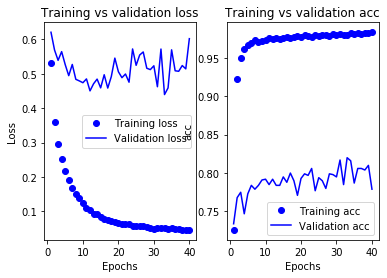

In [72]:

import matplotlib.pyplot as plt

history_dict = history_cnn.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range( 1 , len(loss_values) + 1 ) 

plt.subplot(1,2,1)
plt.plot( epochs , loss_values , 'bo' , label = 'Training loss' )
plt.plot( epochs , val_loss_values , 'b' , label = 'Validation loss' ) 
plt.title( 'Training vs validation loss' ) 
plt.xlabel( 'Epochs' ) 
plt.ylabel( 'Loss' ) 
plt.legend() 

# Here we plot the training and validation accurary side by side.

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']


epochs = range( 1 , len(loss_values) + 1 ) 

plt.subplot(1,2,2)
plt.plot( epochs , acc_values , 'bo' , label = 'Training acc' )
plt.plot( epochs , val_acc_values , 'b' , label = 'Validation acc' ) 
plt.title( 'Training vs validation acc' ) 
plt.xlabel( 'Epochs' ) 
plt.ylabel( 'acc' ) 
plt.legend() 

plt.show()


In [73]:
def test_summary(model, X_test, y_test):
    test_pred = model.predict(X_test).flatten() > 0.5
    test_pred = test_pred.astype('float64')
    print('test accuracy = {}'.format((y_test == test_pred).sum() / len(y_test)))
    print('{} wrongly classified examples in test set'.format((y_test != test_pred).sum()))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    sns.distplot(test_pred, ax=axes[0], kde=False)
    sns.distplot(y_test, ax=axes[0], kde=False)
    sns.scatterplot(range(len(y_test)), y_test, ax=axes[1])
    sns.scatterplot(range(len(y_test)), test_pred, alpha=0.1, ax=axes[1])

for perturbation strength = 0
test accuracy = 0.988
12 wrongly classified examples in test set
for perturbation strength = 1
test accuracy = 0.945
55 wrongly classified examples in test set
for perturbation strength = 3
test accuracy = 0.847
153 wrongly classified examples in test set
for perturbation strength = 5
test accuracy = 0.727
273 wrongly classified examples in test set
for perturbation strength = 7
test accuracy = 0.596
404 wrongly classified examples in test set


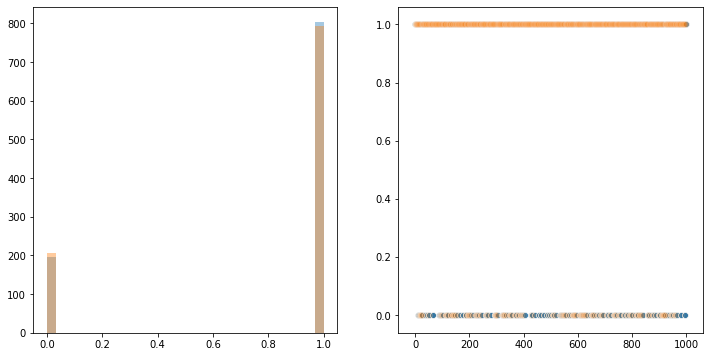

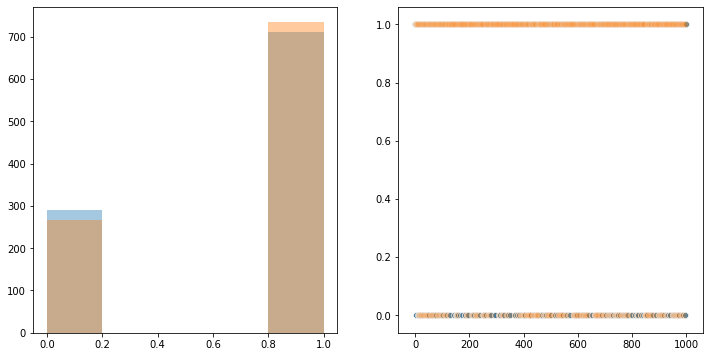

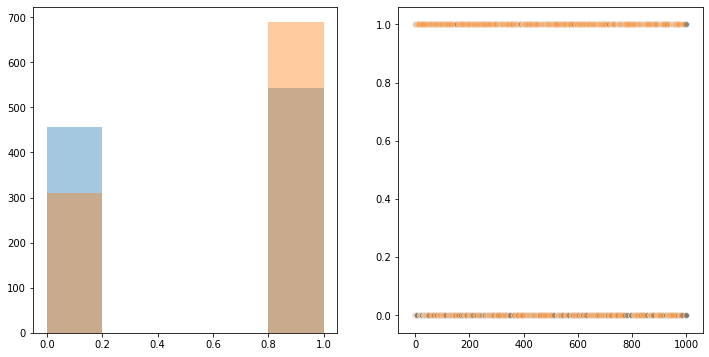

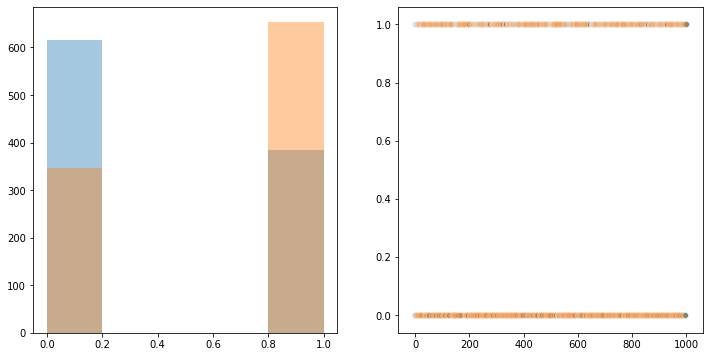

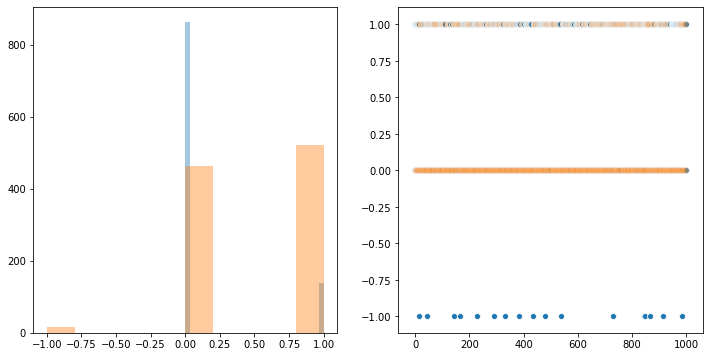

In [74]:
### Test for the test data, of various pert strength

X_test, y_test = load_data( 0 ) 
print( 'for perturbation strength = 0')
test_summary(model_cnn , X_test , y_test )

X_test, y_test = load_data( 1 ) 
print( 'for perturbation strength = 1')
test_summary(model_cnn , X_test , y_test )

X_test, y_test = load_data( 3 ) 
print( 'for perturbation strength = 3')
test_summary(model_cnn , X_test , y_test )

X_test, y_test = load_data( 5 ) 
print( 'for perturbation strength = 5')
test_summary(model_cnn , X_test , y_test )

X_test, y_test = load_data( 7 ) 
print( 'for perturbation strength = 7')
test_summary(model_cnn , X_test , y_test )

## look inside the model

In [ ]:
# def plot_layer_output(h, q):
#     dim_k = h.shape[0]
#     channels = h.shape[-1]
#     # Plot maximum 8 columns per row, channels must be multiples of 8 if channel > 8
#     n_rows = channels // 8 if channels >= 8 else 1
#     n_cols = 8 if channels % 8 == 0 else channels % 8
#     ham = np.zeros((dim_k * n_rows, dim_k * n_cols))
#     for i in range(n_rows):
#         for j in range(n_cols):
#             ham[i * dim_k: (i + 1) * dim_k, j * dim_k: (j + 1) * dim_k] = h[:, :, i * n_cols + j]
#     plt.figure(figsize=(n_cols * 2, n_rows * 2))
#     plt.imshow(ham, cmap='viridis')
#     plt.title('q={}'.format(q))
#     plt.colorbar()

In [ ]:
# def plot_intermediate(model, X, y):
#     X = X.reshape((1, *X.shape))
#     conv_layers = [layer for layer in model.layers if layer.name.startswith('conv2d')]
#     for layer in conv_layers:
#         model_to_layer = Model(inputs=model.input, outputs=layer.output)
#         output = model_to_layer.predict(X)
#         plot_layer_output(output[0], y)

In [ ]:
# from ipywidgets import interact

# @interact(index=(0, train_size - 1, 1))
# def plot_inter(index=0):
#     plot_intermediate(model_cnn, X_train[index], y_train[index])

## Train a deep CNN

In [ ]:
# set_random_seeds(12)
# model_deep_cnn = Sequential()
# model_deep_cnn.add(Conv2D(filters=4, kernel_size=2, activation='relu', input_shape=(num_k, num_k, 32)))
# model_deep_cnn.add(Conv2D(filters=1, kernel_size=1, activation='relu'))
# model_deep_cnn.add(Flatten())
# model_deep_cnn.add(Dense(2, activation='relu'))
# model_deep_cnn.add(Dense(1, activation='linear'))

# model_deep_cnn.summary()

In [ ]:
# batch_size = 50
# num_epochs = 20
# model_deep_cnn.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# history_deep_cnn = model_deep_cnn.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs)

In [ ]:
# model_deep_cnn.save('quad_deep_cnn_model1.h5')

In [ ]:
# mae_deep_cnn = history_deep_cnn.history['mae']
# loss_deep_cnn = history_deep_cnn.history['loss']

# epochs = range(1, len(mae_deep_cnn) + 1)
# fig, axes = plt.subplots(1, 2, figsize=(10, 6))
# axes[0].plot(epochs, mae_deep_cnn)
# axes[1].plot(epochs, loss_deep_cnn)

In [ ]:
# model_summary(model_deep_cnn)

In [ ]:
# X_train.shape

In [ ]:
# y_train.shape